# Análisis de Interconnect

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

## 1. Trabajo previo

### Importar librerías

In [2]:
# Importamos los módulos necesarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Módulos de sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# Otros modelos
from catboost import CatBoostClassifier

# Para trabajar mejor
import typing
from re import sub
from tqdm.auto import tqdm

tqdm.pandas()

/home/hj/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Trabajar con los datos

#### Cargar los datasets

In [3]:
# Creemos dataframes para los valores que tenemos
df_contract = pd.read_csv("data/contract.csv")
df_internet = pd.read_csv("data/internet.csv")
df_personal = pd.read_csv("data/personal.csv")
df_phone = pd.read_csv("data/phone.csv")


In [4]:
# Mostremos la info de los dataframes que tenemos
df_contract.info()
df_internet.info()
df_personal.info()
df_phone.info()

# Estos nos servirá después para limpiar
dataframe_list = [df_contract, df_internet, df_personal, df_phone]
dataframe_list_keys = ["df_contract", "df_internet", "df_personal", "df_phone"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-nu

Parece que no tenemos nulos, pero no necesariamente todos los valores tengan sentido, así que tendremos echar un vistazo a ellos. Por otro lado, pueden existir duplicados y  los nombres de columnas no siguen el formato de _snake case_ así que tendremos que cambiarlos; empecemos con esto último.

#### Cambio de nombres de columnas

In [5]:
# Definamos una función para esto
def snake_caser(var_string: str) -> str:
    return sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1_',var_string).lower()

def snake_caser_list(input_list: list) -> list:
    return [snake_caser(item) for item in input_list]


In [6]:
# Aplicamos
for df in dataframe_list:
    df.columns = snake_caser_list(df.columns)
    print(df.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')
Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')
Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')
Index(['customer_id', 'multiple_lines'], dtype='object')


Se ve mucho mejor, tener las columnas con el nombre apropiado es muy útil para trabajar. Prosigamos a ver si existen duplicados por el customer_id.

#### Revisión de duplicados

In [7]:
# Veamos duplicados por customer_id
print("Duplicados")

for df, key in zip(dataframe_list, dataframe_list_keys):
    print(
        key,": ", len(df[df.duplicated(subset="customer_id")])
    )

Duplicados
df_contract :  0
df_internet :  0
df_personal :  0
df_phone :  0


No tenemos duplicados, ahora echaremos un vistazo rápido a una muestra de elementos de cada dataset para ver que tenemos en cada dataset.

#### Vistazo general de samples

In [8]:
for df, key in zip(dataframe_list, dataframe_list_keys):
    print(key)
    display(
        df.sample(n=10, random_state=12345)
    )
    print()

df_contract


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
1128,0098-BOWSO,2017-11-01,No,Month-to-month,Yes,Electronic check,19.40,529.8
2875,9992-RRAMN,2018-02-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,85.10,1873.7
1783,8380-PEFPE,2019-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,71.65,71.65
3804,9773-PEQBZ,2019-04-01,No,Month-to-month,No,Electronic check,79.85,797.25
6087,8319-QBEHW,2017-12-01,No,One year,Yes,Bank transfer (automatic),39.95,1023.75
2071,3392-EHMNK,2014-07-01,No,Two year,No,Credit card (automatic),94.10,6302.8
2395,6486-LHTMA,2017-07-01,No,One year,Yes,Electronic check,90.70,2835.5
4660,0883-EIBTI,2019-10-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,19.50,31.55
372,6122-EFVKN,2018-02-01,No,Two year,No,Mailed check,35.75,830.8
1143,2446-ZKVAF,2018-08-01,No,Month-to-month,No,Credit card (automatic),56.80,1074.65



df_internet


,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
4878,7823-JSOAG,Fiber optic,No,No,No,No,No,No
5002,4450-YOOHP,DSL,No,No,Yes,No,Yes,Yes
4160,2498-XLDZR,DSL,Yes,Yes,Yes,Yes,No,Yes
683,7905-TVXTA,DSL,Yes,No,No,Yes,Yes,No
1930,9802-CAQUT,Fiber optic,Yes,Yes,Yes,No,Yes,Yes
2140,3387-VATUS,Fiber optic,No,No,No,No,Yes,Yes
2311,2845-AFFTX,Fiber optic,No,No,Yes,No,Yes,Yes
3417,0853-NWIFK,Fiber optic,Yes,Yes,No,No,Yes,Yes
1472,0973-KYVNF,DSL,Yes,Yes,Yes,No,Yes,No
4716,9253-QXKBE,Fiber optic,No,No,No,No,Yes,Yes



df_personal


,customer_id,gender,senior_citizen,partner,dependents
1128,0098-BOWSO,Male,0,No,No
2875,9992-RRAMN,Male,0,Yes,No
1783,8380-PEFPE,Male,0,No,Yes
3804,9773-PEQBZ,Male,0,No,No
6087,8319-QBEHW,Male,0,No,Yes
2071,3392-EHMNK,Female,0,Yes,Yes
2395,6486-LHTMA,Female,1,Yes,No
4660,0883-EIBTI,Female,0,No,No
372,6122-EFVKN,Male,0,No,Yes
1143,2446-ZKVAF,Male,0,Yes,No



df_phone


,customer_id,multiple_lines
1649,8966-KZXXA,Yes
1920,7206-PQBBZ,No
2852,4567-AKPIA,Yes
911,7047-YXDMZ,No
6259,7619-PLRLP,Yes
3581,1304-NECVQ,Yes
5992,9248-OJYKK,Yes
3169,2921-XWDJH,No
3903,9134-WYRVP,No
121,3774-VBNXY,No


Verificaremos que la información esta integra y que no tengamos typos (por ejemplo yes en vez de Yes). 

#### Revisión de datos y cambio de tipos

Iremos tabla por tabla, empezamos con `df_phone`.

In [9]:
df_phone.describe()

,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Todo se ve bien, podemos continuar con `df_personal`.

In [10]:
# Removemos customer_id ya que esos son únicos.
for item in df_personal.drop("customer_id", axis=1).columns:
    print(df_personal[item].unique())

['Female' 'Male']
[0 1]
['Yes' 'No']
['No' 'Yes']


Igual, prosigamos a `df_internet`:

In [11]:
# Removemos customer_id ya que esos son únicos.
for item in df_internet.drop("customer_id", axis=1).columns:
    print(df_internet[item].unique())

['DSL' 'Fiber optic']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


Todo bien, vamos finalmente a `df_contract`.

In [12]:
# Removemos customer_id y los cargos
for item in df_contract.drop(["customer_id", "monthly_charges", "total_charges"], axis=1).columns:
    print(df_contract[item].unique())

['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-11-01' '2014-06-01' '2017-01-01'
 '2015-07-01' '2020-02-01' '2016-11-01' '2013-11-01' '2014-01-01'
 '2013-10-

No hay typos, sin embargo podemos mejorar nuestro trabajo convirtiendo las fechas en objeto fecha. Aquí sin embargo, tenemos un problema: mientrás que para `begin_date` todos los valores son fechas, para `end_date` tenemos el valor _No_, por lo que haremos algo con esto, crearemos una nueva columna llamada `end_service` que será Yes/No y removeremos los No de la columna para poder convertir al tipo datos.

In [13]:
# Para begin_date sin problemas
df_contract.begin_date = df_contract.begin_date.astype("datetime64[ns]")

# Creamos la nueva columna
df_contract["end_service"] = df_contract.end_date.apply(lambda value: "No" if value == "No" else "Yes")

# Removamos los no y cambiemos el tipo
df_contract.end_date = df_contract.end_date.apply(lambda value: "" if value == "No" else value)
df_contract.end_date = df_contract.end_date.astype("datetime64[ns]")

# Mostremos un info para verificar todo
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   end_service        7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 495.3+ KB


Se ve mucho mejor, el hecho de que `end_date` tenga poco menos de 2000 no nulos se debe a que los otros no cancelarán el servicio. Nos falta ver _total_charges_: marca de tipo _object_ pero debería ser númerico al ser un cargo, echemos un vistazo.

In [14]:
df_contract.total_charges.sort_values()

936           
3826          
4380          
753           
5218          
         ...  
6646    997.75
5598     998.1
3686    999.45
3353     999.8
2845     999.9
Name: total_charges, Length: 7043, dtype: object

Al ordenarlos, parece que tenemos muchos valores los cuales están vacíos aunque en info no aparezcan como tal. Limpiemoslo y convirtamos a numérico.

In [15]:
# Cambiamos
df_contract.total_charges = pd.to_numeric(
    df_contract.total_charges.str.strip()
)

#Info
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   end_service        7043 non-null   object        
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 495.3+ KB


Parece que tenemos 11 valores nulos en total_charges, por ahora no los removeremos, pero cuando regresemos al modelado posteriormente imputaremos los valores.

### Merge de los datasets
Como ya hemos limpiado todos los datasets, podemos aprovechar que tenemos datos únicos para hacer el merge entre ellos usando `customer_id` como una llave.

In [16]:
df_merged = df_contract.merge(df_personal).merge(df_phone, "left").merge(df_internet, "left").reset_index(drop=True)

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   end_service        7043 non-null   object        
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  multiple_lines     6361 non-null   object        
 14  internet

Tenemos bastantes nulos porque no todos los usuarios tienen los mismos servicios contratados (por ejemplo quien haya contratado internet sin línea telefónica tendrá vacíos los campos de `multiple_lines`). Para ayudarnos a hacer nuestro análisis, crearemos una nueva columna `services`, la cual indicará si el usuario tiene _phone_, _internet_ o _both_ (ambos). Antes de eso, llenaremos los nulos de las columnas con "NA" para que no sean nulos (a excepción de end_date).

In [17]:
# Lista de columnas a fill
columns_to_fill = list(df_internet.columns)
columns_to_fill.append("multiple_lines")

columns_to_fill.pop(0)
columns_to_fill

# Llenamos
df_merged[columns_to_fill] = df_merged[columns_to_fill].fillna("NA")

Ahora sí, hacemos la nueva columna.

In [18]:
def service_classifier(row):
    if row.multiple_lines == "NA":
        return "Internet"
    elif row.internet_service == "NA":
        return "Phone"
    else:
        return "Both"
        
df_merged["service"] = df_merged.apply(service_classifier, axis=1)

Veamos un pequeño sample de que tenemos para terminar.

In [19]:
df_merged.sample(n=5, random_state=12345)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,end_service,gender,...,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,service
1128,0098-BOWSO,2017-11-01,NaT,Month-to-month,Yes,Electronic check,19.40,529.80,No,Male,...,No,No,NA,NA,NA,NA,NA,NA,NA,Phone
2875,9992-RRAMN,2018-02-01,2019-12-01,Month-to-month,Yes,Electronic check,85.10,1873.70,Yes,Male,...,No,Yes,Fiber optic,No,No,No,No,No,Yes,Both
1783,8380-PEFPE,2019-09-01,2019-10-01,Month-to-month,Yes,Electronic check,71.65,71.65,Yes,Male,...,Yes,No,Fiber optic,No,No,No,No,No,No,Both
3804,9773-PEQBZ,2019-04-01,NaT,Month-to-month,No,Electronic check,79.85,797.25,No,Male,...,No,Yes,Fiber optic,No,Yes,No,No,No,No,Both
6087,8319-QBEHW,2017-12-01,NaT,One year,Yes,Bank transfer (automatic),39.95,1023.75,No,Male,...,Yes,NA,DSL,No,Yes,No,No,Yes,No,Internet


## 2. Análisis exploratorio de datos

Veamos primero como se dividen los usuarios que siguen y los que han abandonado el servicio.

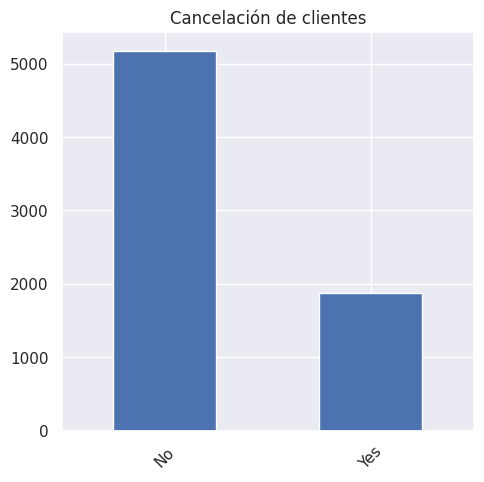

In [20]:
# Usamos set para estar más atractivo
sns.set_theme()
# Ploteamos
df_merged.end_service.value_counts().plot(kind="bar", figsize=(5,5), rot=45)

plt.tight_layout()
plt.xlabel("")
plt.title("Cancelación de clientes")
plt.show()

Tenemos un poco más de 5000 clientes que no han cancelado con casi 2000 que si lo han hecho: una relación de 2 a 5, o sea ~28% del total ha cancelado: es importante buscar una manera de reducir esas métricas. Veamos ahora como se distribuyen en el tipo de servicio que han contratado (internet, telefonía o ambos) y por la forma de facturación.

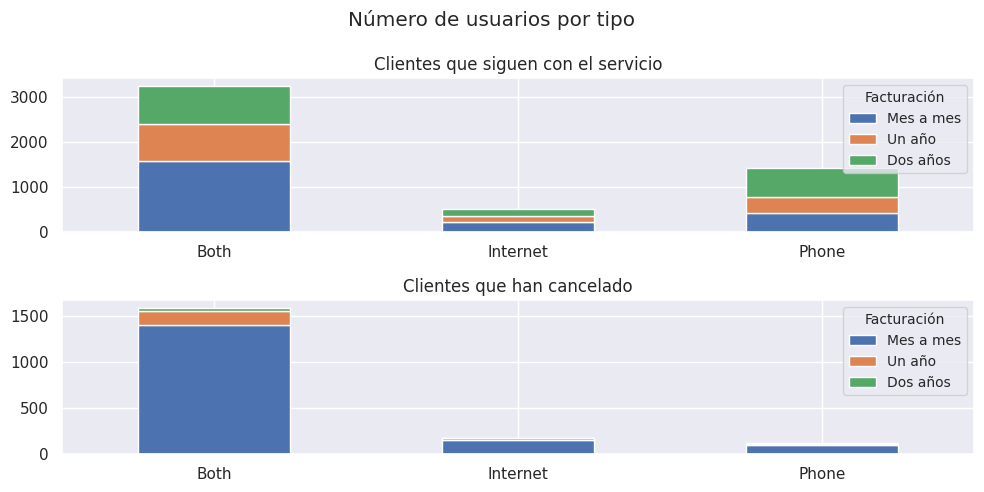

In [21]:
fig, ax = plt.subplots(2,1, figsize=(10, 5))

# New queries
df_no_end_service = df_merged.query("end_service == 'No'")
df_yes_end_service = df_merged.query("end_service == 'Yes'")

#df_merged.query("end_service == 'No'").service.value_counts(normalize=True).plot(kind="bar", ax=ax[0], rot=0)
df_no_end_service.groupby(["service", "type"]).size().unstack().plot(kind="bar", stacked=True, rot=0, ax=ax[0], )

#df_merged.query("end_service == 'Yes'").service.value_counts(normalize=True).plot(kind="bar", ax=ax[1], rot=0)
df_yes_end_service.groupby(["service", "type"]).size().unstack().plot(kind="bar", stacked=True, rot=0, ax=ax[1])

plt.suptitle("Número de usuarios por tipo")

# Embellecemos
for ii in [0,1]:
    ax[ii].set_xlabel("")
    ax[ii].legend(["Mes a mes", "Un año", "Dos años"], title="Facturación", fontsize='small', title_fontsize="small", loc=1)

ax[0].set_title("Clientes que siguen con el servicio")
ax[1].set_title("Clientes que han cancelado")

plt.tight_layout()
plt.show()

De esta figura se aprecia que la mayor cantidad de usuarios siempre es la que tiene ambos servicios contratados. Por el lado de los clientes que han cancelado es muy similar la proporción de los que usan internet contra celular, pero comparando con la de los usuarios que no cancelan podríamos aventurarnos a decir que la proporción de usuarios de internet que cancelan esta sobre representada y los que solo tienen teléfono cancelen menos de lo que uno esperaría. Por otro lado, es asombroso como se comportan los valores por el tipo de facturación: los usuarios que cancelan son principalmente de los que facturan mes a mes, esto puede deberse a no estar en un plazo forzoso. Ahora, también veamos como se comportan los usuarios según las fechas de inicio y de fin.

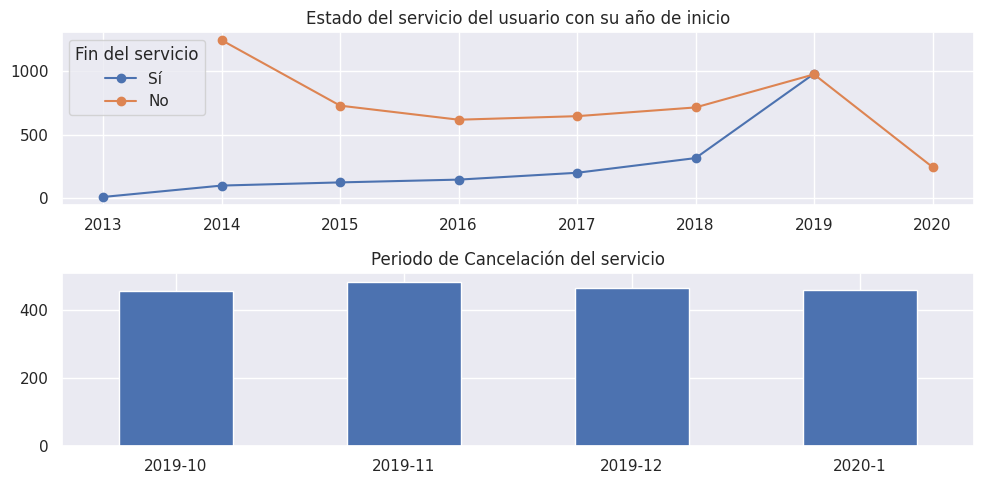

In [22]:
fig, ax = plt.subplots(2,1, figsize=(10, 5))

# Ploteamos begin date
df_yes_end_service.groupby(df_yes_end_service.begin_date.dt.year).begin_date.count().plot(
    kind="line", ax=ax[0], marker="o"
)

df_no_end_service.groupby(df_no_end_service.begin_date.dt.year).begin_date.count().plot(
    kind="line", ax=ax[0], marker="o"
)

ax[0].legend(["Sí", "No"], title="Fin del servicio")
ax[0].set_title("Estado del servicio del usuario con su año de inicio")
ax[0].set_xlabel("")

# Ploteamos end date para los que han cancelado
df_yes_end_service.end_date.value_counts().sort_index().reindex(["2019-10", "2019-11", "2019-12", "2020-1"]).plot(
    kind="bar", ax=ax[1], rot=0
)

ax[1].set_title("Periodo de Cancelación del servicio")
ax[1].set_xlabel("")

plt.tight_layout()
plt.show()

Interesante, de la primer gráfica es claro que los usuarios más antiguos tienden a permanecer en el servicio, mientrás que en fechas más recientes es donde se concentran los que cancelan: desde el 2018 son más comunes. Por otro lado, parece que en aquellos que cancelan, el periodo de cancelación es indiferente al mes: es casi idéntico en los valores que tenemos. Veamos ahora como se distribuye el costo mensual de los usuarios.

Media no han cancelado: 61.26512369540008
Media sí han cancelado: 74.44133226324237


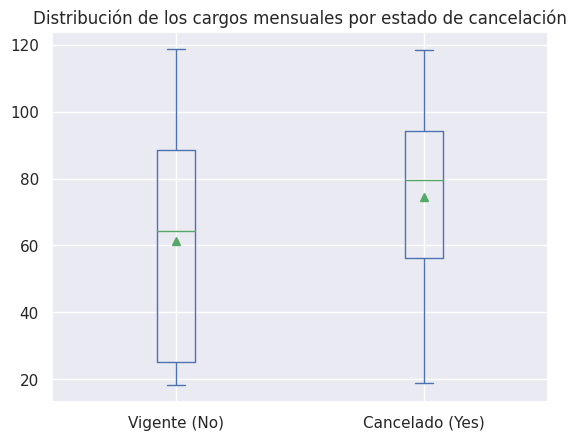

In [23]:
ax = plt.axes()

df_merged.plot(kind="box", column="monthly_charges", by="end_service", showmeans=True, ax=ax)

plt.title("Distribución de los cargos mensuales por estado de cancelación")
ax.set_xticklabels(["Vigente (No)", "Cancelado (Yes)"])

print(f"Media no han cancelado: {df_no_end_service.monthly_charges.mean()}")
print(f"Media sí han cancelado: {df_yes_end_service.monthly_charges.mean()}")

plt.show()

La gráfica de la distribución de los cargos es simple, pero indica que aunque los mínimos y máximos se hallan en posiciones similares, más no los cuartiles, ya que para los que han cancelado es más cerrado el conjunto. Si esto se une a que la mediana (y la media, con el triángulo verde) es mayor en estos nos dice que los usuarios que han cancelado suelen pagar más mensualmente que los que no: esto podría explicar porque terminan su contrato. Mostremos ahora las características sociodemográficas de los usuarios.

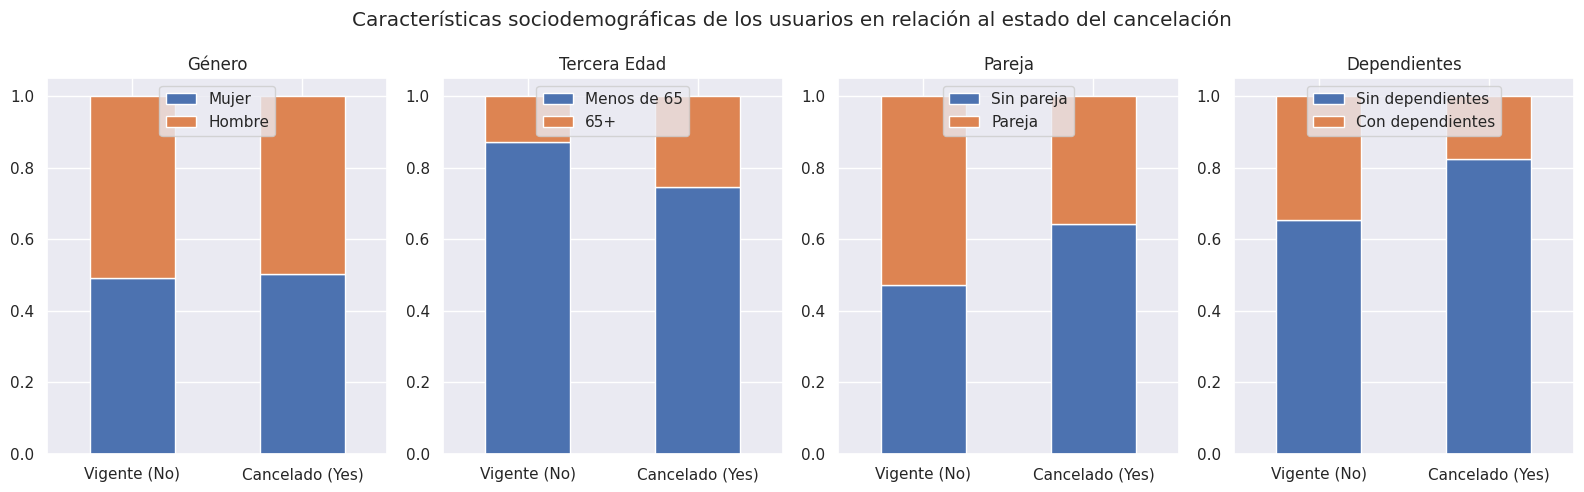

In [24]:
columns_sociodemografico = ["gender", "senior_citizen", "partner", "dependents"]
titulos = ["Género", "Tercera Edad", "Pareja", "Dependientes"]

# Ploteo
fig, ax = plt.subplots(1,4, figsize=(16, 5))

for column, count, title in zip(columns_sociodemografico, [0,1,2,3], titulos):
    df = df_merged.value_counts(["end_service", column], normalize=False).unstack()
    df.div(df.sum(axis=1), axis=0).plot(kind="bar", stacked=True, rot=0, ax=ax[count])
    ax[count].set_title(title)
    ax[count].set_xlabel("")
    ax[count].set_xticklabels(["Vigente (No)", "Cancelado (Yes)"])

# Detalles varios
ax[0].legend(["Mujer", "Hombre"], loc=9)
ax[1].legend(["Menos de 65", "65+"], loc=9)
ax[2].legend(["Sin pareja", "Pareja"], loc=9)
ax[3].legend(["Sin dependientes", "Con dependientes"], loc=9)

plt.suptitle("Características sociodemográficas de los usuarios en relación al estado del cancelación")
plt.tight_layout()
plt.show()

Tenemos varios puntos importantes que mencionar: el género es indistinto en si cancelan o no, no parece haber relación; por otro lado, los usuarios de la tercera edad si parecen cancelar más que los de menor edad, tal vez por falta de uso; en el caso de la pareja sucede que los usuarios que cancelan suelen no tener pareja esto implicaría que debido a ser menos personas que comparten el gasto, no es costable: esto se refuerza con la columna de dependientes, ya que los usuarios que cancelan no suelen tenerlos y absorben el costo completo. 

Ahora, veamos finalmente un análisis de los servicios que contratan con la compañía, sin embargo, tenemos tres tipos de usuarios: los que contratan telefonía, los que contratan internet y aquellos que tienen ambos; no estamos seguros que se comporten igual así que haremos una gráfica para cada grupo.

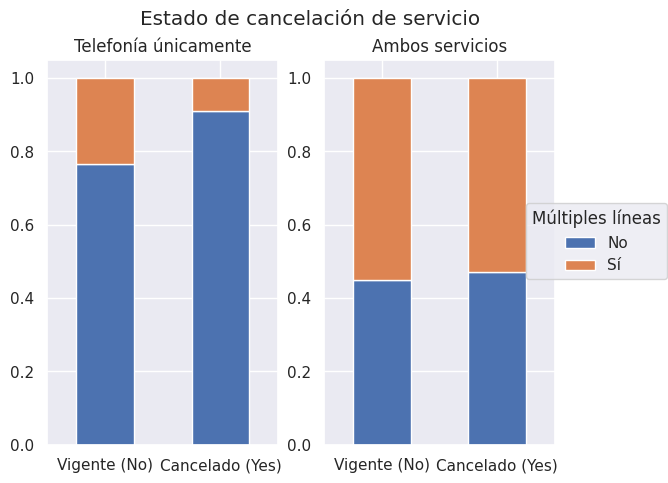

In [25]:
# Definimos df
df_service_internet = df_merged.query("service=='Internet'")
df_service_phone = df_merged.query("service=='Phone'")
df_service_both = df_merged.query("service=='Both'")

# Ploteamos
fig, ax = plt.subplots(1,2, figsize=(7, 5))

ax = ax.flatten()

# Phone multiple lines
df = df_service_phone[["end_service", "multiple_lines"]].value_counts(normalize=True).unstack()
df.div(df.sum(axis=1), axis=0).plot(kind="bar", stacked=True, rot=0, legend=False, ax=ax[0])
ax[0].set_title("Telefonía únicamente")

# Both multiple lines
df = df_service_both[["end_service", "multiple_lines"]].value_counts(normalize=True).unstack()
df.div(df.sum(axis=1), axis=0).plot(kind="bar", stacked=True, rot=0, legend=False, ax=ax[1])
ax[1].set_title("Ambos servicios")

# Embellecemos
for ii in [0,1]:
    ax[ii].set_xticklabels(["Vigente (No)", "Cancelado (Yes)"])
    ax[ii].set_xlabel("")

fig.legend(["No", "Sí"], title="Múltiples líneas", borderaxespad=0.1, loc=7)

plt.subplots_adjust(right=0.85)
plt.suptitle("Estado de cancelación de servicio")
#plt.tight_layout()
plt.show()

Parece que cuando el cliente tiene ambos servicios el tener múltiples líneas es igual para cancelar o no la línea, sin embargo, cuando solo se tiene telefonía la mayoría de los usuarios que cancela no tiene múltiples líneas. Veamos que sucede ahora con el internet.

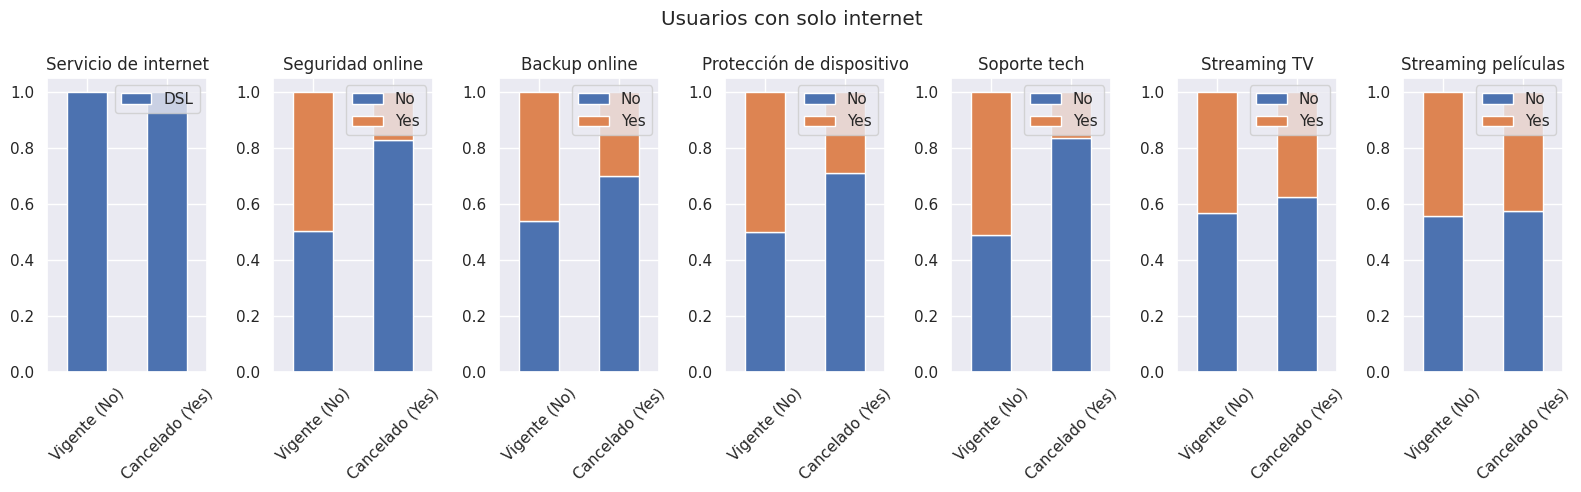

In [26]:
# Columnas
columns_internet = list(df_internet.columns)
columns_internet.pop(0)
titulos = [
    "Servicio de internet", "Seguridad online", "Backup online", "Protección de dispositivo", "Soporte tech", "Streaming TV", "Streaming películas"
]

# Ploteo
fig, ax = plt.subplots(1, len(columns_internet), figsize=(16, 5))

for column, count, title in zip(columns_internet, list(range(len(columns_internet))), titulos):
    df = df_service_internet.value_counts(["end_service", column], normalize=False).unstack()
    df.div(df.sum(axis=1), axis=0).plot(kind="bar", stacked=True, rot=45, ax=ax[count])
    ax[count].set_title(title)
    ax[count].set_xlabel("")
    ax[count].set_xticklabels(["Vigente (No)", "Cancelado (Yes)"])
    ax[count].legend().set_title("")

plt.suptitle("Usuarios con solo internet")
plt.tight_layout()
plt.show()

Para los usuarios que solo tienen internet tenemos que solo cuentan con DSL, y que en lo general los que cancelan son más propensos a tener menos servicios contratados que aquellos que no han cancelado. Solo la proporción es similar para el streaming en general. Veamos que sucede con los usuarios que tienen ambos servicios.

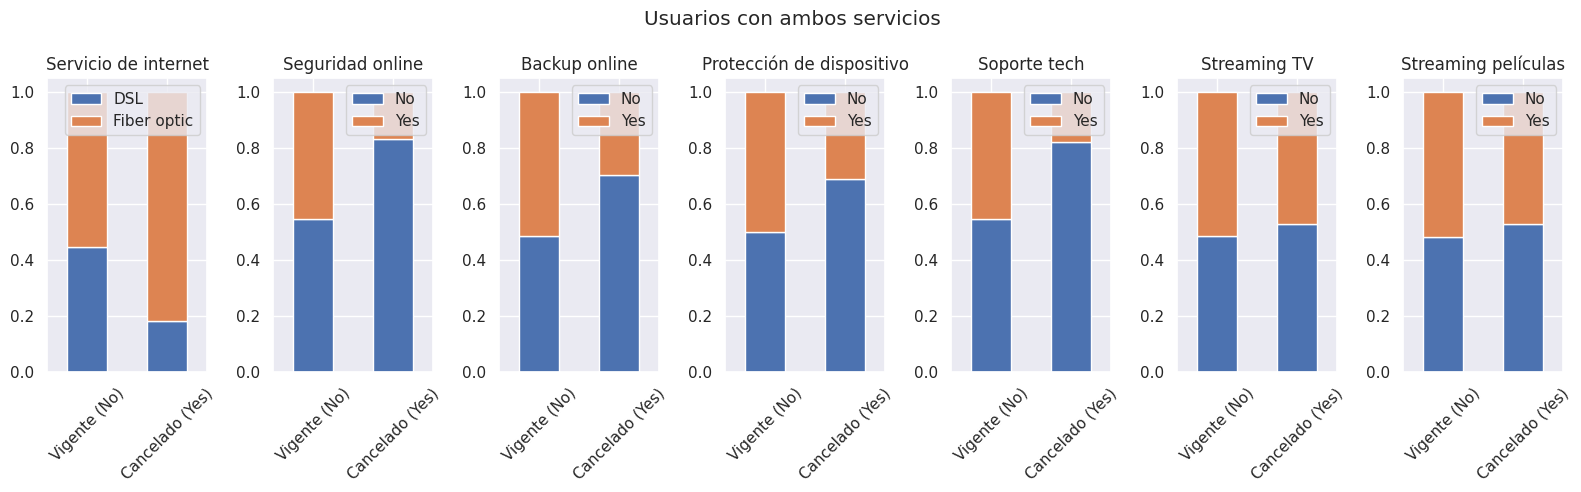

In [27]:
# Ploteo
fig, ax = plt.subplots(1, len(columns_internet), figsize=(16, 5))

for column, count, title in zip(columns_internet, list(range(len(columns_internet))), titulos):
    df = df_service_both.value_counts(["end_service", column], normalize=False).unstack()
    df.div(df.sum(axis=1), axis=0).plot(kind="bar", stacked=True, rot=45, ax=ax[count])
    ax[count].set_title(title)
    ax[count].set_xlabel("")
    ax[count].set_xticklabels(["Vigente (No)", "Cancelado (Yes)"])
    ax[count].legend().set_title("")

plt.suptitle("Usuarios con ambos servicios")
plt.tight_layout()
plt.show()

Cuando tenemos usuarios con ambos servicios ahora si tenemos contratación con fibra óptica, parece que cancelan más si tienen fibra óptica. Aquí se cumple muy similar a cuando solo tienen un servicio: los usuarios que contratan menos servicios son los que cancelan: tal vez es muy caro para los clientes.

### Conclusiones

Podemos dar unas conclusiones iniciales de este análisis exploratorio:
1.  Apróximadamente 28% de los clientes ha cancelado el servicio hasta el momento, y las cancelaciones se concentran en el periodo octubre 2019 a enero 2020.
2.  La cancelación se concentra en usuarios que pagan mes a mes, probablemente por la facilidad de cancelar el contrato.
3.  Los usuarios que cancelan suelen pagar más en promedio que aquellos que se quedan con el servicio (74.44 contra 61.27 dólares)
4.  Sociodemográficamente es indistinto si son hombres o mujeres, pero los usuarios mayores tienden a cancelar más; al igual, no tener dependientes o pareja es indicador de mayor propensión a cancelar (probablemente la carga de pagar sea mayor.)
5.  Aquellos usuarios que contratan fibra óptica parecen ser más propensos a cancelar el servicio, tal vez haya problemas con éste.
6.  Los usuarios que cancelan suelen gastar menos en el resto de servicios añadidos, a excepción de streaming que es igual para los que no cancelan.

## 3. Preguntas aclaratorias

1.  ¿Tenemos información más detallada de las edades de los usuarios para poder clasificarlos en grupos más precisos? ¿Lo mismo pero para los datos sociodemográficos en general?
2.  ¿Existen valores para los precios que se tienen en cada tipo de pago? ¿Es igual si se paga mensual, anual, bianual? ¿Los servicios adicionales tienen un costo extra?
3.  ¿Sabemos en qué tipo de dispositivos se conectan primordialmente los usuarios (celulares, computadoras, étc.)?
4.  ¿Existe información de la región geográfica en que se hallan los usuarios? Tal vez el servicio sea malo/bueno por zonas.

## 4. Plan de trabajo

1.  Imputar los valores nulos en la columna de _total_charges_
2.  Crear features para entrenar los modelos: definir el número de días entre el inicio hasta el final (o a la última fecha si no ha cancelado); también hacer el encoding para poder entrenar bien.
3. Realizar upsampling para las categorías que tenemos y combatir el desbalanceo de clases.
4.  Dividir en los conjuntos de entrenamiento, prueba y validación.
5. Modelar con regresión logística, árbol de decisión y bosque aleatorio.

## 5. Ingeniería de características

Antes de continuar, revisemos cuales son las 11 entradas que tenemos con valores
nulos y veamos que hacer con ellas.

In [28]:
df_merged.query("total_charges.isnull()")

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,end_service,gender,...,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,service
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,No,Female,...,Yes,NA,DSL,Yes,No,Yes,Yes,Yes,No,Internet
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,No,Male,...,Yes,No,NA,NA,NA,NA,NA,NA,NA,Phone
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,No,Female,...,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Both
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,NaN,No,Male,...,Yes,Yes,NA,NA,NA,NA,NA,NA,NA,Phone
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,NaN,No,Female,...,Yes,NA,DSL,Yes,Yes,Yes,Yes,Yes,No,Internet
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,NaN,No,Male,...,Yes,No,NA,NA,NA,NA,NA,NA,NA,Phone
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,NaN,No,Male,...,Yes,Yes,NA,NA,NA,NA,NA,NA,NA,Phone
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,NaN,No,Female,...,Yes,No,NA,NA,NA,NA,NA,NA,NA,Phone
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,NaN,No,Male,...,Yes,No,NA,NA,NA,NA,NA,NA,NA,Phone
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,NaN,No,Female,...,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Both


Interesante, todas las entradas tienen la misma fecha, recordemos que este es nuestro cutoff para los datos: no tenemos datos posteriores. Como no sabemos realmente como se pueden haber comportado, preferiremos quitarlos y quedarnos únicamente con los demás para no alterar nuestro modelo.

In [29]:
df_non_null = df_merged.query("~total_charges.isnull()").reset_index(drop=True)

df_non_null.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   end_service        7032 non-null   object        
 9   gender             7032 non-null   object        
 10  senior_citizen     7032 non-null   int64         
 11  partner            7032 non-null   object        
 12  dependents         7032 non-null   object        
 13  multiple_lines     7032 non-null   object        
 14  internet

Mucho mejor, ahora empezaremos con la preparación de características para nuestros modelos. Primero, removeremos el customer_id ya que no lo necesitamos.

In [30]:
# Removemos el customer_id
df_non_null = df_non_null.drop("customer_id", axis=1)

Ahora, transformaremos las fechas: podríamos separar las fechas en mes y años creando nuevas columnas o podríamos reemplazar las fechas por una duración (el delta entre la fecha de inicio y fecha final) del servicio. No todos los valores han cancelado, así que no tienen fecha de finalización, por lo que usaremos la última (2020-02-01) para esto y removeremos las columnas de fecha originales.

In [31]:
# Agregamos los valores de end date para los vacíos
df_non_null.end_date = df_non_null.end_date.fillna("2020-02-01")

# Calculamos duración
df_non_null["duration"] = (df_non_null.end_date - df_non_null.begin_date).dt.days

# Removemos las columnas que no usaremos
df_non_null = df_non_null.drop(["begin_date", "end_date"], axis=1)

# Mostramos un sample
df_non_null.sample(n=5, random_state=12345)

,type,paperless_billing,payment_method,monthly_charges,total_charges,end_service,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,service,duration
3276,Two year,Yes,Electronic check,94.80,4690.65,No,Male,0,Yes,No,No,Fiber optic,No,Yes,No,No,Yes,Yes,Both,1492
1620,Month-to-month,Yes,Bank transfer (automatic),75.75,655.90,Yes,Female,0,Yes,No,No,Fiber optic,No,No,Yes,No,No,No,Both,273
4598,Two year,No,Mailed check,25.00,300.70,No,Female,0,Yes,Yes,Yes,NA,NA,NA,NA,NA,NA,NA,Phone,337
5434,Month-to-month,No,Electronic check,45.45,1233.15,No,Male,0,No,No,No,DSL,No,No,No,No,No,No,Both,792
2757,Two year,No,Bank transfer (automatic),99.30,2513.50,No,Male,0,No,No,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Both,761


Se me mucho mejor, ahora reemplazaremos el NA que aparece en las columnas para solo tener _Yes_ y _No_, que será útil cuando hagamos el encoding justo después. También cambiaremos la columna 

In [32]:
# Reemplazamos NA
df_non_null = df_non_null.replace("NA", "No")

# Coding
df_ohe = pd.get_dummies(df_non_null, drop_first=True)

# Cambiemos la columna target, end_service_Yes a su propia columna target
df_ohe["target_cancelacion"] = df_ohe.end_service_Yes

df_ohe = df_ohe.drop("end_service_Yes", axis=1)

# Mostremos
df_ohe.sample(n=5, random_state=12345)


,monthly_charges,total_charges,senior_citizen,duration,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,...,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,service_Internet,service_Phone,target_cancelacion
3276,94.80,4690.65,0,1492,False,True,True,False,True,False,...,False,False,True,False,False,True,True,False,False,False
1620,75.75,655.90,0,273,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,True
4598,25.00,300.70,0,337,False,True,False,False,False,True,...,True,False,False,False,False,False,False,False,True,False
5434,45.45,1233.15,0,792,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2757,99.30,2513.50,0,761,False,True,False,False,False,False,...,False,False,False,True,True,True,True,False,False,False


Esta mejor, ahora haremos un pequeño cambio para nuestro entrenamiento realizando el escalado de las features.

In [33]:
# Escalemos las variables numéricas
columnas_numericas = ["monthly_charges", "total_charges", "duration"]

# Definimos el escalador y aplicamos
df_scaled = df_ohe.copy()
scaler = StandardScaler()
scaler.fit(df_scaled[columnas_numericas])

df_scaled[columnas_numericas] = scaler.transform(df_scaled[columnas_numericas])

# Mostramos
df_scaled.sample(n=5, random_state=12345)

,monthly_charges,total_charges,senior_citizen,duration,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,...,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,service_Internet,service_Phone,target_cancelacion
3276,0.997273,1.062092,0,0.675226,False,True,True,False,True,False,...,False,False,True,False,False,True,True,False,False,False
1620,0.364042,-0.717989,0,-0.956416,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,True
4598,-1.322910,-0.874698,0,-0.870751,False,True,False,False,False,True,...,True,False,False,False,False,False,False,False,True,False
5434,-0.643143,-0.463313,0,-0.261730,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2757,1.146855,0.101561,0,-0.303224,False,True,False,False,False,False,...,False,False,False,True,True,True,True,False,False,False


Con los datos escalados podemos proceder a entrenar nuestros modelos, sin embargo recordemos que nuestras clases estan desbalanceadas: hagamos un value counts para mostrar esto.

In [34]:
# Mostremos nuestros valores
df_scaled.target_cancelacion.value_counts()

target_cancelacion
False    5163
True     1869
Name: count, dtype: int64

Tenemos 5163 contra 1869 valores, para no eliminar entradas, hagamos upsampling triplicando las entradas que si han cancelado.

In [35]:
# Dividimos
df_false = df_scaled[df_scaled.target_cancelacion==False]
df_true = df_scaled[df_scaled.target_cancelacion==True]

# Upsample
df_true_upsampled = resample(
    df_true, replace=True, n_samples=df_false.shape[0], random_state=12345
)

df_upsampled = pd.concat([df_false, df_true_upsampled])

# Veamos que tenemos
df_upsampled.target_cancelacion.value_counts()

target_cancelacion
False    5163
True     5163
Name: count, dtype: int64

Perfecto, podemos ir al entrenamiento.

## Entrenamiento de modelos

Empezaremos realizando la división en nuestros conjuntos de entrenamiento, validación y prueba. Usaremos la proporción 60:20:20 para esto.

In [36]:
# Definamos nuestras features y target
df_features = df_upsampled.drop("target_cancelacion", axis=1)
df_targets = df_upsampled.target_cancelacion

# Los dos splits
x_train, x_test, y_train, y_test = train_test_split(
  df_features, df_targets, test_size=0.2, random_state=12345
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.25, random_state=12345
)

# Veamos tamaños

print(
    f"Tamaño de x train: {x_train.shape[0]}, y train: {y_train.shape[0]}"
)

print(
    f"Tamaño de x test: {x_test.shape[0]}, y test: {y_test.shape[0]}"
)

print(
    f"Tamaño de x validacion: {x_val.shape[0]}, y test: {y_val.shape[0]}"
)


Tamaño de x train: 6195, y train: 6195
Tamaño de x test: 2066, y test: 2066
Tamaño de x validacion: 2065, y test: 2065


Perfecto, ahora podemos continuar con nuestro entrenamiento de modelos. Vayamos con el modelo más simple, de clasificación vía regresión logística.

### Modelo de regresión logística

Nuestro modelo de regresión logística más sencilla, sin hiperpárametros; usaremos estos valores como un benchmark mínimo para comparar los siguientes modelos.

In [37]:
model_lr = LogisticRegression()
model_lr.fit(x_train, y_train)

# Scores
print(
    f"Accuracy: {accuracy_score(y_val, model_lr.predict(x_val))}"
)

print(
    f"ROC-AUC: {roc_auc_score(y_val, model_lr.predict(x_val))}"
)


Accuracy: 0.7317191283292979
ROC-AUC: 0.7313660430175313


Tenemos un ROC-AUC de 0.7313 y una Accuracy de 0.7317. Mucho menos de los valores que esperamos alrededor de 0.85, vamos con un modelo más complejo: árboles de decisión.

### Modelo de árboles de decisión

In [38]:
# Definimos párametros
param_grid = {
    "max_features": ["sqrt", "log2"],
    "ccp_alpha": [0.1, .01, .001],
    "max_depth" : [3, 5, 7, 9],
    "criterion" : ["gini", "entropy"]
}

# Modelo
model_tree = DecisionTreeClassifier(random_state=12345)
grid_search = GridSearchCV(
    estimator=model_tree, param_grid=param_grid, cv=5, verbose=2, scoring="roc_auc", error_score='raise', return_train_score = False
)
grid_search.fit(
    x_train,#.replace([True, False], [1,0]),
    y_train#.replace([True, False], [1,0])
)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=3, max_features=sqrt; total time=   0.1s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=3, max_features=sqrt; total time=   0.1s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=3, max_features=sqrt; total time=   0.1s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=3, max_features=sqrt; total time=   0.1s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=3, max_features=sqrt; total time=   0.1s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=3, max_features=log2; total time=   0.1s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=3, max_features=log2; total time=   0.1s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=3, max_features=log2; total time=   0.1s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=3, max_features=log2; total time=   0.1s
[CV] END ccp_alpha=0.1, criterion=gini, max_depth=3, max_features=log2; total time=   0.1s
[CV] END ccp_alpha=0.1, crit

GridSearchCV(cv=5, error_score='raise',
             estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 9],
                         'max_features': ['sqrt', 'log2']},
             scoring='roc_auc', verbose=2)

In [39]:
# Mostremos los mejores párametros
grid_search.best_params_

{'ccp_alpha': 0.001,
 'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 'sqrt'}

In [40]:
# Probamos
model_tree = DecisionTreeClassifier(
    ccp_alpha=0.001, criterion='entropy', max_depth=9, max_features='sqrt', random_state=12345
)

model_tree.fit(x_train, y_train)

# Scores
print(
    f"Accuracy: {accuracy_score(y_val, model_tree.predict(x_val))}"
)

print(
    f"ROC-AUC: {roc_auc_score(y_val, model_tree.predict(x_val))}"
)


Accuracy: 0.7418886198547215
ROC-AUC: 0.7413009951368876


Tenemos un ROC-AUC de 0.7418 y una Accuracy de 0.7413. Todavía podemos ir mejorando, probemos con otros modelos.

## Modelo CatBoost

In [40]:
# Definimos párametros
param_grid = {
    "depth": [2, 4, 8, 16],
    "learning_rate": [0.1, 0.01, 0.001],
    "iterations": [10, 50, 100]
}

# Modelo
model_catboost = CatBoostClassifier(random_state=12345)
grid_search = GridSearchCV(
    estimator=model_catboost, param_grid=param_grid, cv=5, verbose=2, scoring="roc_auc", error_score='raise', return_train_score = False
)

# Hacemos el ajuste
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0:	learn: 0.6618597	total: 50.2ms	remaining: 452ms
1:	learn: 0.6360674	total: 55.2ms	remaining: 221ms
2:	learn: 0.6159813	total: 61.7ms	remaining: 144ms
3:	learn: 0.5954778	total: 66ms	remaining: 99ms
4:	learn: 0.5793954	total: 70.9ms	remaining: 70.9ms
5:	learn: 0.5672043	total: 74.6ms	remaining: 49.8ms
6:	learn: 0.5588124	total: 80.2ms	remaining: 34.4ms
7:	learn: 0.5486799	total: 83.8ms	remaining: 20.9ms
8:	learn: 0.5394232	total: 87ms	remaining: 9.66ms
9:	learn: 0.5309562	total: 97.4ms	remaining: 0us
[CV] END ..........depth=2, iterations=10, learning_rate=0.1; total time=   0.9s
0:	learn: 0.6621716	total: 3ms	remaining: 27ms
1:	learn: 0.6347458	total: 7.79ms	remaining: 31.1ms
2:	learn: 0.6135928	total: 10.9ms	remaining: 25.5ms
3:	learn: 0.5936290	total: 14.1ms	remaining: 21.1ms
4:	learn: 0.5779439	total: 19.2ms	remaining: 19.2ms
5:	learn: 0.5650170	total: 22.3ms	remaining: 14.9ms
6:	learn: 0.5559312	total: 27.5ms	remainin

GridSearchCV(cv=5, error_score='raise',
             estimator=<catboost.core.CatBoostClassifier object at 0x7f6b41377e20>,
             param_grid={'depth': [2, 4, 8, 16], 'iterations': [10, 50, 100],
                         'learning_rate': [0.1, 0.01, 0.001]},
             scoring='roc_auc', verbose=2)

In [41]:
# Mostramos mejores párametros
grid_search.best_params_

{'depth': 16, 'iterations': 100, 'learning_rate': 0.1}

In [41]:
# Probamos
model_catboost = CatBoostClassifier(
    depth=16, iterations=100, learning_rate=0.1, random_state=12345
)

# Ajustamos
model_catboost.fit(x_train, y_train)

0:	learn: 0.6225170	total: 2.62s	remaining: 4m 18s
1:	learn: 0.5645565	total: 6.04s	remaining: 4m 56s
2:	learn: 0.5208925	total: 9.46s	remaining: 5m 5s
3:	learn: 0.4993904	total: 9.47s	remaining: 3m 47s
4:	learn: 0.4595407	total: 11s	remaining: 3m 28s
5:	learn: 0.4268704	total: 12.9s	remaining: 3m 21s
6:	learn: 0.3998860	total: 14.3s	remaining: 3m 9s
7:	learn: 0.3747737	total: 16.9s	remaining: 3m 14s
8:	learn: 0.3554636	total: 19.8s	remaining: 3m 20s
9:	learn: 0.3384851	total: 22.4s	remaining: 3m 21s
10:	learn: 0.3234690	total: 24.9s	remaining: 3m 21s
11:	learn: 0.3095626	total: 26.7s	remaining: 3m 15s
12:	learn: 0.2961750	total: 29.3s	remaining: 3m 16s
13:	learn: 0.2845556	total: 31.2s	remaining: 3m 11s
14:	learn: 0.2743753	total: 32.5s	remaining: 3m 4s
15:	learn: 0.2629925	total: 34.2s	remaining: 2m 59s
16:	learn: 0.2560185	total: 35.8s	remaining: 2m 54s
17:	learn: 0.2475086	total: 38s	remaining: 2m 52s
18:	learn: 0.2430805	total: 40.6s	remaining: 2m 53s
19:	learn: 0.2362970	total: 4

In [64]:
# Hagamos unos pequeños cambios por la naturaleza de las predicciones del modelo, cambiemos todo a 0s y 1s en vez de False y True.
predictions = model_catboost.predict(x_val)
predictions[predictions == "True"] = 1
predictions[predictions == "False"] = 0
predictions = predictions.astype(int)

y_val_integer = y_val.replace([True, False], [1,0])

# Scores
print(
    f"Accuracy: {accuracy_score(y_val_integer, predictions)}"
)

print(
    f"ROC-AUC: {roc_auc_score(y_val_integer, predictions)}"
)

Accuracy: 0.8789346246973365
ROC-AUC: 0.8785357003482228


In [65]:
predictions = model_catboost.predict(x_test)
predictions[predictions == "True"] = 1
predictions[predictions == "False"] = 0
predictions = predictions.astype(int)

y_test_integer = y_test.replace([True, False], [1,0])

# Scores
print(
    f"Accuracy: {accuracy_score(y_test_integer, predictions)}"
)

print(
    f"ROC-AUC: {roc_auc_score(y_test_integer, predictions)}"
)

Accuracy: 0.8852855759922555
ROC-AUC: 0.8838215874730833


In [70]:
model_catboost.get_weight()

AttributeError: 'CatBoostClassifier' object has no attribute 'get_weight'